<a href="https://colab.research.google.com/github/ChanglinWu/DL/blob/main/MLP5_CIFAR10_BN_Dropout_58_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CityU EE5438: Applied Deep Learning

## PyTorch Multi-Layer Perceptron (MLP) With CIFAR-10 Color Image Dataset

In this example, we demonstrate how to train a MLP model (aka feedforward neural network)  to classify images from the CIFAR-10 dataset. The RGB-color images are flattened into a 3072-dimensional vector before being fed into the network.


<img src='https://www.ee.cityu.edu.hk/~lmpo/ee5438/images/mlp_cifar10.png'>


The CIFAR-10 dataset is a widely used collection of images that is commonly used to train machine learning and computer vision algorithms

- It consists of 60,000 32x32 color images in 10 different classes
- Each class contains 6,000 images, with 5,000 images for training and 1,000 images for testing
- The 10 different classes in the CIFAR-10 dataset represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks

<!-- <img src='https://corochann.com/wp-content/uploads/2021/09/cifar10_plot.png'> -->


References:
- [Image Classifier using PyTorch and Keras](https://medium.com/dataseries/image-classifier-using-pytorch-and-keras-555007a50c2e)

- [Basic Syntax of the Markdown elements.](https://www.markdownguide.org/basic-syntax/)

In [ ]:
# Install the torchinfo package for showing the network architecture information
!pip install torchinfo -qqq

In [ ]:
# Import the necessary libraries for working with CIFART-10 dataset and PyTorch.
import torch
import torchvision
from torchvision import datasets,transforms
import torch.nn as nn
import torch.nn.functional as F
from torch import nn,optim,no_grad
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
from torchinfo import summary

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import pickle
import sys
import time

In [ ]:
# To configure the usage of a GPU (cuda) or MPS (Apple) if either of them is available
has_mps = torch.backends.mps.is_built()
device = "cuda" if torch.cuda.is_available() else "mps" if has_mps else "cpu"
print(f"Python versoin: {sys.version_info.major, sys.version_info.minor, sys.version_info.micro}")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

Python versoin: (3, 10, 12)
PyTorch version: 2.1.0+cu121
Device: cuda


In [ ]:
# Set seed for reproducibility
seed = 4016
torch.manual_seed(seed)

# Download CIFAR10 Dataset

This piece of code helps in downloading and managing the training and test data for a model. The training dataset used is called CIFAR-10 and it has 50,000 training samples. The test dataset is divided into two parts: a validation set and a test set, each with 5,000 samples. The data loaders help in providing batches of data from these datasets for the model to train on. The training data consists of batches of images, where each image is a 32 x 32 pixel color image. The corresponding labels indicate the correct class for each image, such as airplanes, cars, birds, cats, etc.


In [ ]:
# Define data transformations for the training and test sets
train_transform = transforms.Compose([
    #  transforms.RandomHorizontalFlip(p=0.5),
    #  transforms.RandomAffine(degrees=(-5, 5), translate=(0.1, 0.1), scale=(0.9, 1.1)),
     transforms.ToTensor(), # Convert images to tensors
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))]) # Normalize the image data

test_transform = transforms.Compose([
     transforms.ToTensor(), # Convert images to tensors
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))]) # Normalize the image data

# Create the CIFAR10dataset for the training set with 50,000 images
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)

# Create the CIFAR10 dataset for the test set with 10,000 images
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# Split the original test set into a validation set with 5,000 samples and a test set with 5,000 samples
val_set, test_set = torch.utils.data.random_split(test_dataset, [5000, 5000])

# Define the data loaders for the training, validation, and test sets
train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=256, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=False, num_workers=2)

# Define the classes for the CIFAR-10 dataset
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


100%|██████████| 170498071/170498071 [02:58<00:00, 954016.29it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


##Visualize image for each class
The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

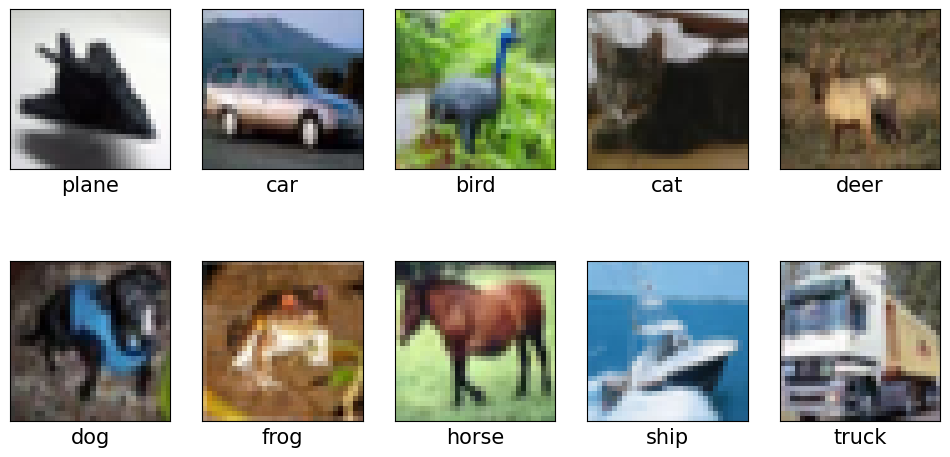

In [ ]:
# Visualize training image for each class
sample_images = [train_set.data[np.asarray(train_set.targets) == label][0] for label in range(10)]
# show images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(classes[i], fontsize=15)
    axis.imshow(sample_images[i])
    i += 1

# Define the MLP Network Architecture

The following code defines a class called MLPNet which inherits from nn.Module. The network has 5 fully-connected layers:

- fc1 takes the 784-pixel Fashion MNIST image as input and outputs 1024 nodes
- fc2 takes the 128 nodes and outputs 512 nodes
- fc2 takes the 128 nodes and outputs 256 nodes
- fc2 takes the 128 nodes and outputs 128 nodes
- fc3 takes the 64 nodes and outputs predictions for the 10 classes

The forward method defines the forward pass through the network. It applies batch normalization, ReLU activation and dropout regularization on the first 4 layers and log softmax on the output layer

In [ ]:
## Define the MLP architecture with Batch Normalization and Dropout Regularization

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.dropout3 = nn.Dropout(0.2)
        self.fc4 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(0.2)
        self.fc5 = nn.Linear(128, 10)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 32*32*3)
        x = self.activation(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.activation(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)
        x = self.activation(self.fc3(x))
        x = self.bn3(x)
        x = self.dropout3(x)
        x = self.activation(self.fc4(x))
        x = self.bn4(x)
        x = self.dropout4(x)
        x = self.fc5(x)
        return F.log_softmax(x, dim=1)

In [ ]:
model = MLP()

## Print the Model Structure and Number of Parameters

In [ ]:
summary(model=model, input_size=(1, 3, 32, 32), col_width=15,
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape     Output Shape    Param #         Trainable
MLP (MLP)                                [1, 3, 32, 32]  [1, 10]         --              True
├─Linear (fc1)                           [1, 3072]       [1, 1024]       3,146,752       True
├─ReLU (activation)                      [1, 1024]       [1, 1024]       --              --
├─BatchNorm1d (bn1)                      [1, 1024]       [1, 1024]       2,048           True
├─Dropout (dropout1)                     [1, 1024]       [1, 1024]       --              --
├─Linear (fc2)                           [1, 1024]       [1, 512]        524,800         True
├─ReLU (activation)                      [1, 512]        [1, 512]        --              --
├─BatchNorm1d (bn2)                      [1, 512]        [1, 512]        1,024           True
├─Dropout (dropout2)                     [1, 512]        [1, 512]        --              --
├─Linear (fc3)                           [1, 512]        [1, 25

## Specify Loss Function and Optimizer
It's recommended that you use cross-entropy loss for classification. If you look at the documentation (linked above), you can see that PyTorch's cross entropy function applies a softmax funtion to the output layer and then calculates the log loss.

In [ ]:
# Specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# Specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Specify learning rate scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, verbose=True)

# Other optimizers
# optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

##Training the Network
The steps for training/learning from a batch of data are described in the comments below:

Clear the gradients of all optimized variables Forward pass: compute predicted outputs by passing inputs to the model Calculate the loss Backward pass: compute gradient of the loss with respect to model parameters Perform a single optimization step (parameter update) Update average training loss The following loop trains for 100 epochs; take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data.

In [ ]:
# Create a Models folder to store the checkpoints
!mkdir Models

In [ ]:
EPOCHS = 100

loss_hist, acc_hist = [], []  # Lists to store training loss and accuracy
loss_hist_val, acc_hist_val = [], []  # Lists to store validation loss and accuracy

model.to(device)  # Move the model to the specified device (e.g., GPU)

print("Training was started.\n")

for epoch in range(1, EPOCHS + 1):
    time_ckpt = time.time()
    print("EPOCH:", epoch, end=" ")
    running_loss = 0.0
    correct = 0

    # Training loop
    for data in train_loader:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)

        optimizer.zero_grad()  # Clear the gradients
        outputs = model(batch)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass (compute gradients)
        optimizer.step()  # Update the model's parameters

        # Compute training statistics
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_set)  # Average training loss for the epoch
    avg_acc = correct / len(train_set)  # Average training accuracy for the epoch
    loss_hist.append(avg_loss)
    acc_hist.append(avg_acc)

    # Validation statistics
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        loss_val = 0.0
        correct_val = 0

        # Validation loop
        for data in val_loader:
            batch, labels = data
            batch, labels = batch.to(device), labels.to(device)
            outputs = model(batch)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            loss_val += loss.item()

        avg_loss_val = loss_val / len(val_set)  # Average validation loss for the epoch
        avg_acc_val = correct_val / len(val_set)  # Average validation accuracy for the epoch
        loss_hist_val.append(avg_loss_val)
        acc_hist_val.append(avg_acc_val)

    model.train()  # Set the model back to training mode
    scheduler.step(avg_loss_val) # Check the scheduler for updating the learning rate

    # Save the model at the end of each epoch
    with open("Models/MLP_model_{}.pth".format(epoch), "wb") as f:
        model.eval()
        pickle.dump(model, f)
        model.train()

    print("Train Loss: {:.3f}".format(avg_loss * 100), end=" ")
    print("Val Loss: {:.3f}".format(avg_loss_val * 100), end=" ")
    print("Train Accuracy: {:.2f}%".format(avg_acc * 100), end=" ")
    print("Val Accuracy: {:.2f}%".format(avg_acc_val * 100), end=" ")
    print("Time: {:.2f}s".format(time.time() - time_ckpt), end=" \n")


Training was started.

EPOCH: 1 Train Loss: 0.736 Val Loss: 0.652 Train Accuracy: 33.21% Val Accuracy: 42.24% Time: 7.34s 
EPOCH: 2 Train Loss: 0.642 Val Loss: 0.605 Train Accuracy: 41.95% Val Accuracy: 46.28% Time: 6.91s 
EPOCH: 3 Train Loss: 0.604 Val Loss: 0.583 Train Accuracy: 45.40% Val Accuracy: 48.20% Time: 7.45s 
EPOCH: 4 Train Loss: 0.577 Val Loss: 0.563 Train Accuracy: 47.92% Val Accuracy: 49.44% Time: 6.94s 
EPOCH: 5 Train Loss: 0.557 Val Loss: 0.548 Train Accuracy: 49.50% Val Accuracy: 51.14% Time: 7.36s 
EPOCH: 6 Train Loss: 0.539 Val Loss: 0.550 Train Accuracy: 51.23% Val Accuracy: 51.56% Time: 6.89s 
EPOCH: 7 Train Loss: 0.523 Val Loss: 0.538 Train Accuracy: 52.56% Val Accuracy: 51.24% Time: 7.08s 
EPOCH: 8 Train Loss: 0.509 Val Loss: 0.537 Train Accuracy: 53.79% Val Accuracy: 52.30% Time: 6.95s 
EPOCH: 9 Train Loss: 0.495 Val Loss: 0.526 Train Accuracy: 55.24% Val Accuracy: 53.62% Time: 7.03s 
EPOCH: 10 Train Loss: 0.484 Val Loss: 0.522 Train Accuracy: 56.13% Val Accura

## Plotting Training Statistics

Loss is a function of the difference of the network output and the target values. We are minimizing the loss function during training so it should decrease over time. Accuracy is the classification accuracy for the test data.

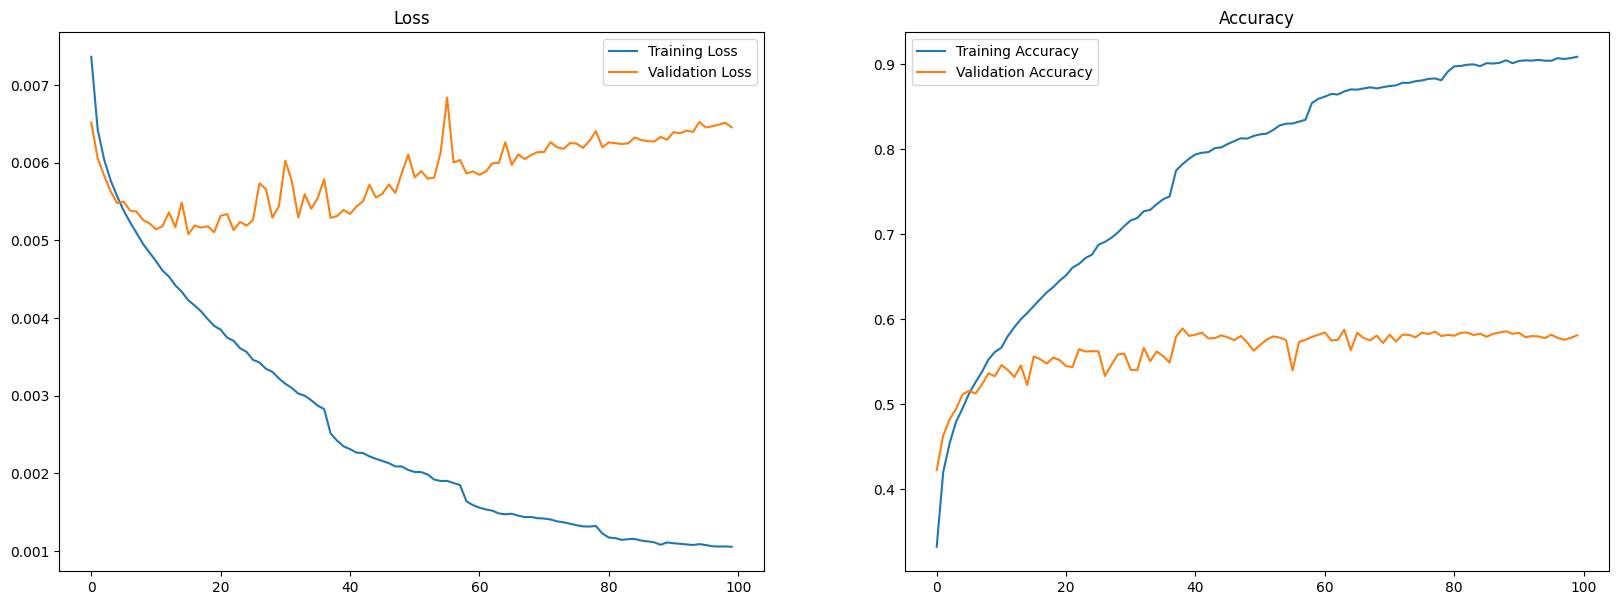

In [ ]:
plots=[(loss_hist,loss_hist_val),(acc_hist,acc_hist_val)]
plt_labels=[("Training Loss","Validation Loss"),("Training Accuracy","Validation Accuracy")]
plt_titles=["Loss","Accuracy"]
plt.figure(figsize=(20,7))
for i in range(0,2):
    ax=plt.subplot(1,2,i+1)
    ax.plot(plots[i][0],label=plt_labels[i][0])
    ax.plot(plots[i][1],label=plt_labels[i][1])
    ax.set_title(plt_titles[i])
    ax.legend()

##Save the trained model

In [ ]:
# from google.colab import files
# torch.save(model.state_dict(), 'checkpoint.pth')
# # download checkpoint file
# files.download('checkpoint.pth')
# model.load_state_dict(torch.load('checkpoint.pth'))

In [ ]:
# Selecting the best model
best_acc = max(acc_hist_val)
best_epoch = acc_hist_val.index(best_acc)+1

print("Best accuracy on validation set: {:.2f}%".format(best_acc*100))
print("Best epoch: {}".format(best_epoch))

# Load the best model
with open(f"Models/MLP_model_{best_epoch}.pth","rb") as f:
    model=pickle.load(f)

Best accuracy on validation set: 58.90%
Best epoch: 39


##Test the Trained Network
Finally, we test our best model on previously unseen test data and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

In [ ]:
pred_vec = []
label_vec = []
correct = 0
test_loss = 0.0

model.to(device)
model.eval()
with torch.no_grad():
    for data in test_loader:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = model(batch)
        test_loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        pred_vec.extend(predicted.cpu().numpy())  # Convert tensor to numpy array
        label_vec.extend(labels.cpu().numpy())  # Convert tensor to numpy array

pred_vec = np.array(pred_vec)
label_vec = np.array(label_vec)

# Print the Test Set Accuracy

In [ ]:
print(F"Test Loss: {test_loss:.2f}")
print(F"Test Accuracy on the {len(test_set)} test images is {(100 * correct / len(test_set)):.2f}%" )

Test Loss: 1.58
Test Accuracy on the 5000 test images is 58.02%


# Display the Confusion Matrix

In [ ]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(label_vec, pred_vec)
# Convert confusion matrix to pandas DataFrame
labels = np.unique(label_vec)
confusion_df = pd.DataFrame(confusion_mat, index=classes, columns=classes)
print("Confusion Matrix")
confusion_df

Confusion Matrix


,plane,car,bird,cat,deer,dog,frog,horse,ship,truck
plane,306,6,23,8,17,5,14,8,58,24
car,24,326,11,10,8,3,10,9,22,68
bird,33,5,220,45,70,31,55,33,7,8
cat,17,6,35,200,39,96,59,29,13,8
deer,12,3,58,40,281,17,53,46,8,9
dog,8,1,28,119,41,228,24,27,8,5
frog,1,8,27,46,41,19,353,8,5,5
horse,12,3,21,30,51,34,11,309,5,17
ship,50,25,10,16,7,8,4,4,369,17
truck,31,60,11,20,8,7,10,17,26,309


# Compute the Accuracy, F1-Score, Precision, Recall, Support

In [ ]:
# Create a report to show the f1-score, precision, recall
from sklearn.metrics import classification_report

report = pd.DataFrame.from_dict(classification_report(pred_vec,label_vec,output_dict=True)).T
report['Label']=[classes[int(x)] if x.isdigit() else " " for x in report.index]
report=report[['Label','f1-score','precision','recall','support']]
report

,Label,f1-score,precision,recall,support
0,plane,0.635514,0.652452,0.619433,494.0000
1,car,0.698073,0.663951,0.735892,443.0000
2,bird,0.462671,0.433925,0.495495,444.0000
3,cat,0.386100,0.398406,0.374532,534.0000
4,deer,0.515596,0.533207,0.499112,563.0000
5,dog,0.486660,0.466258,0.508929,448.0000
6,frog,0.638336,0.688109,0.595278,593.0000
7,horse,0.628688,0.626775,0.630612,490.0000
8,ship,0.715810,0.723529,0.708253,521.0000
9,truck,0.637771,0.619238,0.657447,470.0000


In the context of classification, 'support' refers to the number of instances or samples in a dataset that belong to a specific class. It represents the frequency or count of occurrences of each class in the dataset.

Support values help assess the reliability and generalizability of classification models, as they indicate the amount of data available for each class and the potential challenges associated with imbalanced datasets.

# Visualize Sample Test Results
This cell displays test images and their labels in this format: predicted (ground-truth). The text will be green for accurately classified examples and red for incorrect predictions.

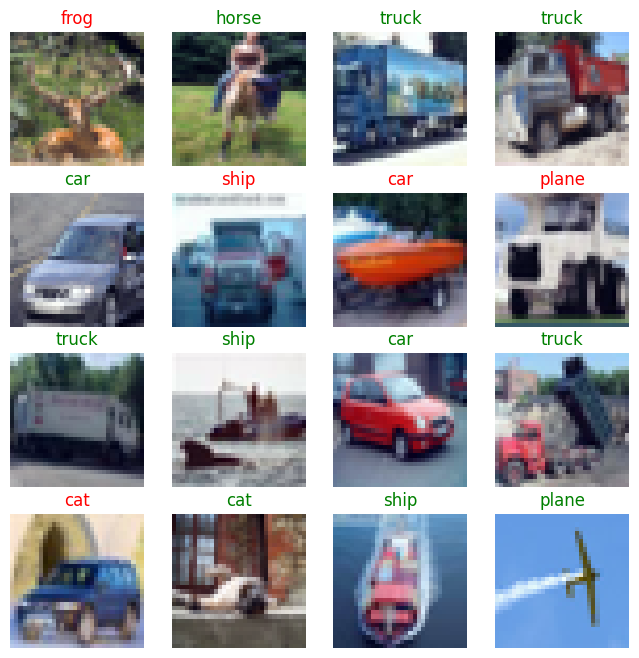

In [ ]:
# obtain one batch of test images
images, labels = next(iter(test_loader))
model.cpu()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)

# Create a 4x4 grid for displaying the images
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

# Iterate over the images and display them in the grid
for idx, ax in enumerate(axes.flat):
  # Normalize the image tensor to [0, 1] range
  image = images[idx].permute(1, 2, 0)
  image = (image - image.min()) / (image.max() - image.min())
  ax.imshow(image)  # Display the image
  ax.axis('off')  # Hide the axes
  ax.set_title("{}".format(classes[preds[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))  # Add title to the image
plt.show()

#Display 50 Predicted Images
We iterate through 50 images and plot them with their corresponding label. We will color the label in blue if our model guessed correct and in red if it failed to predict that class.

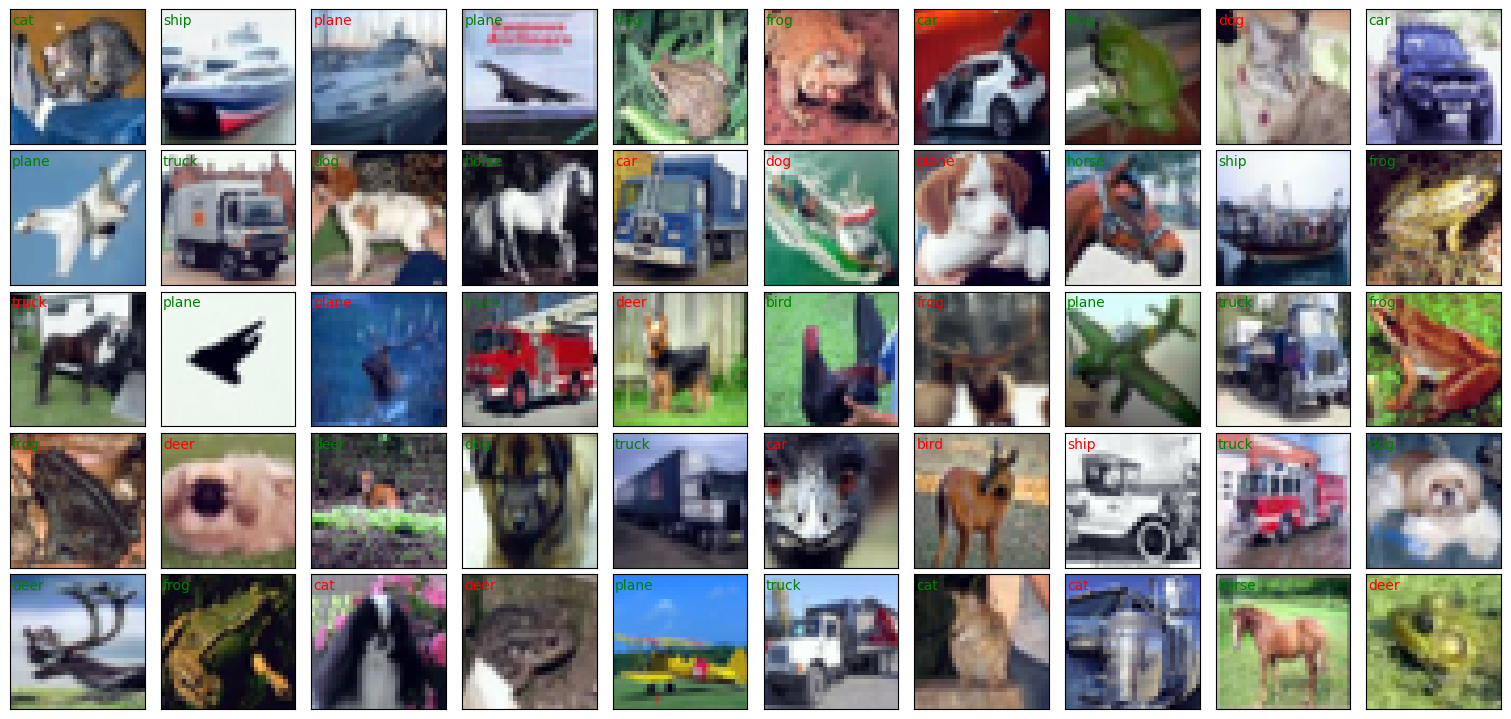

In [ ]:
# Define the loader for all test data
test_set_all = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=test_transform)
test_loader_all = torch.utils.data.DataLoader(test_set_all, batch_size=128, shuffle=False, num_workers=2)


# obtain one batch of test images
dataiter = iter(test_loader_all)
images, labels = next(iter(test_loader_all))
model.cpu()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)


fig = plt.figure(figsize=(15, 7))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for idx in range(50):
    # Normalize the image tensor to [0, 1] range
    image = images[idx].permute(1, 2, 0)
    image = (image - image.min()) / (image.max() - image.min())
    ax = fig.add_subplot(5, 10, idx + 1, xticks=[], yticks=[])
    ax.imshow(image, interpolation='nearest')

    if preds[idx]==labels[idx]:
      ax.text(0, 3, str(classes[preds[idx].item()]), color='green')
    else:
      ax.text(0, 3, str(classes[preds[idx].item()]), color='red')

plt.show()


#Visualize wrongly classified image for each class

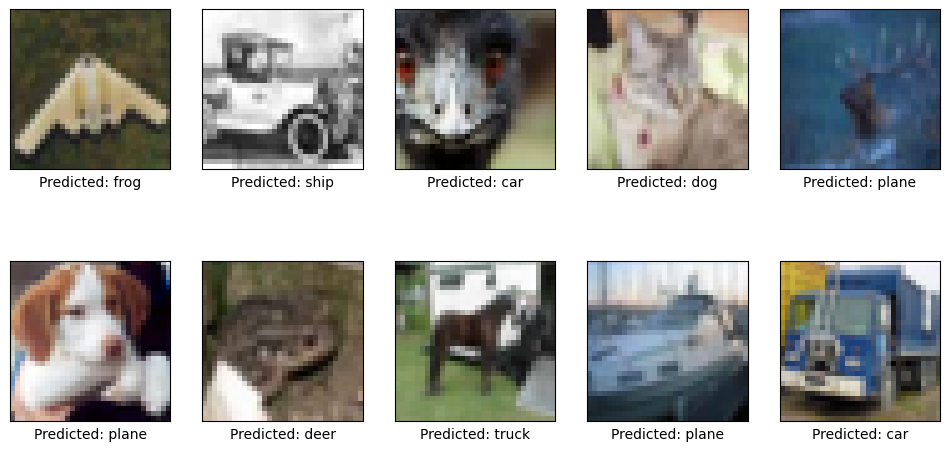

In [ ]:
# Visualize wrongly classified image for each class
pred_vec_all = []
correct = 0
test_loss = 0.0

model.to(device)

with torch.no_grad():
    for data in test_loader_all:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = model(batch)
        test_loss=criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        pred_vec_all.append(predicted)
    pred_vec_all = torch.cat(pred_vec_all)

pred_vec_all = pred_vec_all.cpu().numpy()
ground_truths = np.asarray(test_set_all.targets)
incorrect_mask = pred_vec_all != ground_truths
incorrect_images = [test_set_all.data[(ground_truths == label) & incorrect_mask][0] for label in range(10)]
pred_results_all = [pred_vec_all[(ground_truths == label) & incorrect_mask][0] for label in range(10)]

# show images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel("Predicted: %s" % classes[pred_results_all[i]], fontsize=10)
    axis.imshow(incorrect_images[i], cmap='gray')
    i += 1